In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
import sys
sys.path.append('../Models')
from models import TimeSeriesNeuralNetwork, LSTMTimeSeriesModel
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


### Reading the merged dataframe

In [40]:
data = pd.read_csv('../Data/Final_table.csv')

,datetime_beginning_ept,MIDATL_solar,OTHER_solar,RFC_solar,RTO_solar,SOUTH_solar,WEST_solar,MIDATL_wind,OTHER_wind,RFC_wind,...,DOM_forecast,DUQ_forecast,EKPC_forecast,MIDATL_forecast,RTO_forecast,DPL_historical_da,forecast_gen_outage_mw_rto,forecast_gen_outage_mw_west,forecast_gen_outage_mw_other,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,18/02/2022 00:00:00 AM,0.282,0.0,0.041,0.0,0.0,0.0,957.466,0.000,5625.364,...,9663.600000,1254.400000,1313.600000,24893.800000,78417.800000,38.95,2928.770833,257.166667,2671.604167,4.61
1,18/02/2022 01:00:00 AM,0.246,0.0,0.000,0.0,0.0,0.0,939.014,0.000,5291.098,...,9394.800000,1233.000000,1334.200000,24153.400000,76642.200000,36.43,2928.770833,257.166667,2671.604167,4.61
2,18/02/2022 02:00:00 AM,0.300,0.0,0.060,0.0,0.0,0.0,904.381,0.000,4676.792,...,9239.400000,1224.200000,1365.400000,23656.600000,75794.400000,36.36,2928.770833,257.166667,2671.604167,4.61
3,18/02/2022 03:00:00 AM,0.254,0.0,0.015,0.0,0.0,0.0,889.508,0.000,3968.681,...,9250.600000,1229.000000,1428.800000,23673.400000,75983.400000,36.59,2928.770833,257.166667,2671.604167,4.61
4,18/02/2022 04:00:00 AM,0.270,0.0,0.034,0.0,0.0,0.0,863.901,0.000,3413.737,...,9458.500000,1270.166667,1537.000000,24108.166667,77849.166667,38.60,2928.770833,257.166667,2671.604167,4.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17251,06/02/2024 19:00:00 PM,0.000,0.0,0.000,0.0,0.0,0.0,61.862,32.860,724.760,...,16275.111111,1601.333333,1941.666667,36055.333333,104239.777778,38.47,1981.593407,123.285714,1858.307692,2.10
17252,06/02/2024 20:00:00 PM,0.000,0.0,0.000,0.0,0.0,0.0,53.747,32.555,1023.869,...,16309.222222,1588.444444,1977.777778,35548.333333,103658.666667,34.93,1981.593407,123.285714,1858.307692,2.10
17253,06/02/2024 21:00:00 PM,0.000,0.0,0.000,0.0,0.0,0.0,55.560,31.433,1273.961,...,16058.444444,1552.333333,1971.222222,34477.000000,101522.777778,32.97,1981.593407,123.285714,1858.307692,2.10
17254,06/02/2024 22:00:00 PM,0.000,0.0,0.000,0.0,0.0,0.0,41.071,29.998,1428.095,...,15672.400000,1497.200000,1927.400000,32638.700000,97698.300000,30.20,1981.593407,123.285714,1858.307692,2.10


### Splitting the dataframe into test and training sets

In [41]:
feature_var = data.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28]]
target_var = data['DPL_historical_da']

X_train, X_test, y_train, y_test = train_test_split(feature_var, target_var, test_size=0.2, random_state=156)

# Feature Selection

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Initiate the SelectKBest model
model_fc = SelectKBest(score_func=f_classif, k=4)

# Fit the model to all data
diabetes_new = model_fc.fit(X_train, y_train)

# Check the selected features
diabetes_new.get_feature_names_out()

array(['APS_forecast', 'MIDATL_forecast', 'RTO_forecast',
       'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'],
      dtype=object)

In [43]:
optimized_features = feature_var.iloc[:,diabetes_new.get_support()]
optimized_features


,APS_forecast,MIDATL_forecast,RTO_forecast,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,4884.400000,24893.800000,78417.800000,4.61
1,4814.400000,24153.400000,76642.200000,4.61
2,4829.200000,23656.600000,75794.400000,4.61
3,4840.200000,23673.400000,75983.400000,4.61
4,4997.500000,24108.166667,77849.166667,4.61
...,...,...,...,...
17251,6669.222222,36055.333333,104239.777778,2.10
17252,6662.222222,35548.333333,103658.666667,2.10
17253,6538.000000,34477.000000,101522.777778,2.10
17254,6352.400000,32638.700000,97698.300000,2.10


In [44]:
target_var

0        38.95
1        36.43
2        36.36
3        36.59
4        38.60
         ...  
17251    38.47
17252    34.93
17253    32.97
17254    30.20
17255    27.97
Name: DPL_historical_da, Length: 17256, dtype: float64

In [45]:
data.columns

Index(['datetime_beginning_ept', 'MIDATL_solar', 'OTHER_solar', 'RFC_solar',
       'RTO_solar', 'SOUTH_solar', 'WEST_solar', 'MIDATL_wind', 'OTHER_wind',
       'RFC_wind', 'RTO_wind', 'SOUTH_wind', 'WEST_wind', 'AEP_forecast',
       'APS_forecast', 'ATSI_forecast', 'COMED_forecast', 'DAY_forecast',
       'DEOK_forecast', 'DOM_forecast', 'DUQ_forecast', 'EKPC_forecast',
       'MIDATL_forecast', 'RTO_forecast', 'DPL_historical_da',
       'forecast_gen_outage_mw_rto', 'forecast_gen_outage_mw_west',
       'forecast_gen_outage_mw_other',
       'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'],
      dtype='object')

# Linear Regression

# Neural Network

## Functions for Module

In [46]:
def train_model (model, train_loader, criterion, optimizer, device, num_epochs=100):
    epoch_losses = []

    for epoch in range(num_epochs):
        batch_losses = []  
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

    return epoch_losses

In [47]:
def plot_loss_over_epochs(epoch_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

In [48]:
def test_model(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
 
        y_pred_tensor = model(X_test_tensor)

        y_pred = y_pred_tensor.cpu().numpy()
        y_true = y_test_tensor.cpu().numpy()

        print(f"predicted value: {y_pred.shape}", f"true value: {y_true.shape}")
    
    mse = mean_squared_error(y_true, y_pred)
    print(f"Mean Squared Error on the Test Set: {mse}")

    r2 = r2_score(y_true, y_pred)
    print(f"R^2 Score: {r2}")

    return y_pred, y_true, mse, r2


In [49]:
def plot_actual_predicted(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values', alpha=0.75)
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.show()
    

In [50]:
def plot_distribution_error(errors):
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=25, edgecolor='k', alpha=0.7)
    plt.xlabel('Error Value')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()

## Convert the data to tensor

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
X_tensor = torch.tensor(feature_var.to_numpy(), dtype=torch.float32)
X_tensor_opti = torch.tensor(optimized_features.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(target_var.to_numpy(), dtype=torch.float32)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor_opti, y_tensor, test_size=0.2, random_state=42)

In [54]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


## First Network

In [55]:
model = TimeSeriesNeuralNetwork(sequence_length=1, num_features=X_train.shape[1], output_size=1).to(device)

In [56]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [57]:
epoch_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)


/Users/jeevanparmar/Uni/Third_Year/MSCI446/MSCI_446_ML_Course_Project/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jeevanparmar/Uni/Third_Year/MSCI446/MSCI_446_ML_Course_Project/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 12981201.51509603
Epoch 2, Loss: 3827.3992306744613
Epoch 3, Loss: 3086.1492029825845
Epoch 4, Loss: 2965.953335797345
Epoch 5, Loss: 3028.4397382382995
Epoch 6, Loss: 3059.615969622577
Epoch 7, Loss: 3027.134708545826
Epoch 8, Loss: 3185.3205741599754
Epoch 9, Loss: 3538.3459950199835
Epoch 10, Loss: 3481.936363220215
Epoch 11, Loss: 3704.665978043168
Epoch 12, Loss: 3900.721792432997
Epoch 13, Loss: 4926.805335998535
Epoch 14, Loss: 8835.31376252351
Epoch 15, Loss: 12834.991294578269
Epoch 16, Loss: 55140.17632689299
Epoch 17, Loss: 50540.62690339265
Epoch 18, Loss: 108939.13958259865
Epoch 19, Loss: 5158.541851467557
Epoch 20, Loss: 7849.762420089157
Epoch 21, Loss: 13840.0627178616
Epoch 22, Loss: 17179.52421400282
Epoch 23, Loss: 17288.780230486835
Epoch 24, Loss: 23733.029638219763
Epoch 25, Loss: 8697.713904345477
Epoch 26, Loss: 15596.320054230866
Epoch 27, Loss: 11809.903333310727
Epoch 28, Loss: 10224.00405742504
Epoch 29, Loss: 9427.131911666305
Epoch 30, Loss

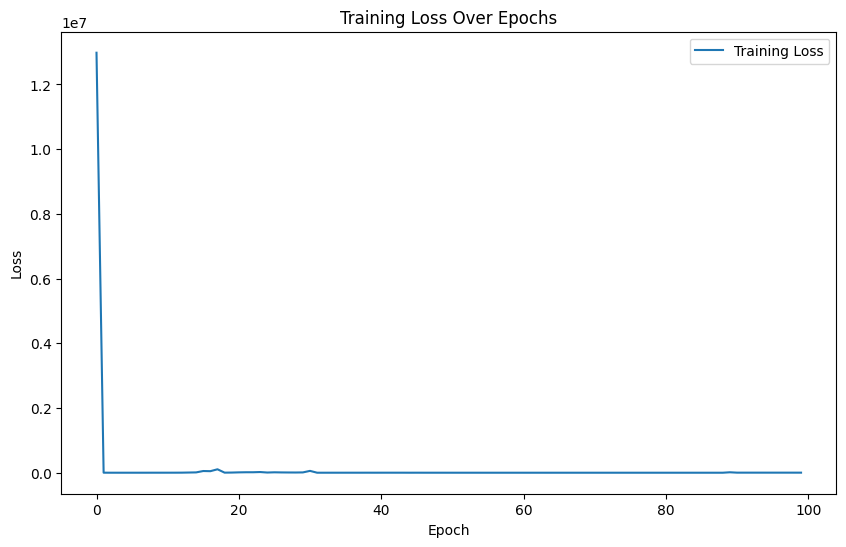

In [58]:
plot_loss_over_epochs(epoch_losses)

In [59]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


model.eval()

y_pred, y_true, mse, r2 = test_model(model, X_test_tensor, y_test_tensor)

predicted value: (3452, 1) true value: (3452,)
Mean Squared Error on the Test Set: 4407.6064453125
R^2 Score: -0.7906381762240329


/var/folders/8z/yxhm1c6x4bvg_s6d6w0cl6_80000gn/T/ipykernel_10310/1134563720.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/8z/yxhm1c6x4bvg_s6d6w0cl6_80000gn/T/ipykernel_10310/1134563720.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


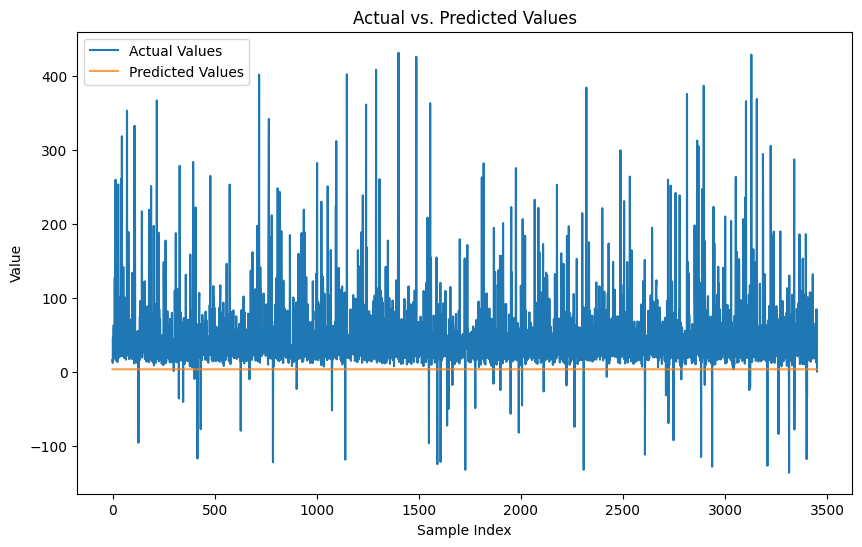

In [60]:
plot_actual_predicted(y_true, y_pred)


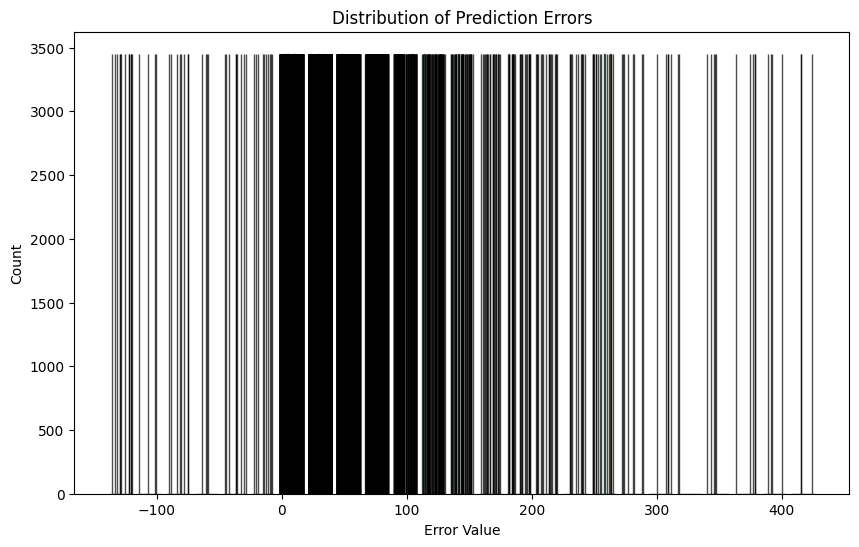

In [61]:
errors = y_true - y_pred
plot_distribution_error(errors)

## Model Parameters

In [62]:
sequence_length = 1
num_features = X_train.shape[1]    
output_size = 1       
hidden_dim = 50       
num_layers = 2        
dropout_rate = 0.2    



## Making Tensors 3-D

In [63]:
X_train = X_train.view(-1, sequence_length, num_features)
X_test = X_test.view(-1, sequence_length, num_features)

In [64]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Second Network

In [65]:
model = LSTMTimeSeriesModel(sequence_length, num_features, output_size, hidden_dim, num_layers, dropout_rate).to(device)

In [66]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
epoch_losses = train_model(model, train_loader, criterion, optimizer, device, num_epochs=100)

/Users/jeevanparmar/Uni/Third_Year/MSCI446/MSCI_446_ML_Course_Project/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jeevanparmar/Uni/Third_Year/MSCI446/MSCI_446_ML_Course_Project/venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 4670.575905128761
Epoch 2, Loss: 3741.2414107146087
Epoch 3, Loss: 3287.481267010724
Epoch 4, Loss: 3024.5633581655998
Epoch 5, Loss: 2869.3249280011214
Epoch 6, Loss: 2784.688194840043
Epoch 7, Loss: 2754.153667308666
Epoch 8, Loss: 2730.3314039442275
Epoch 9, Loss: 2724.888878433793
Epoch 10, Loss: 2719.0426473264342
Epoch 11, Loss: 2723.806813557943
Epoch 12, Loss: 2729.22686513265
Epoch 13, Loss: 2721.344220196759
Epoch 14, Loss: 2719.7479024816444
Epoch 15, Loss: 2735.5429647940177
Epoch 16, Loss: 2718.1432486640083
Epoch 17, Loss: 2721.756170484755
Epoch 18, Loss: 2723.2339599044235
Epoch 19, Loss: 2719.7712764033563
Epoch 20, Loss: 2719.6535415649414
Epoch 21, Loss: 2719.901182951751
Epoch 22, Loss: 2719.43369434498
Epoch 23, Loss: 2721.0780362729674
Epoch 24, Loss: 2718.4951448793763
Epoch 25, Loss: 2720.223959463614
Epoch 26, Loss: 2718.9354413350425
Epoch 27, Loss: 2718.265061555085
Epoch 28, Loss: 2722.668899253563
Epoch 29, Loss: 2728.137151647497
Epoch 30, L

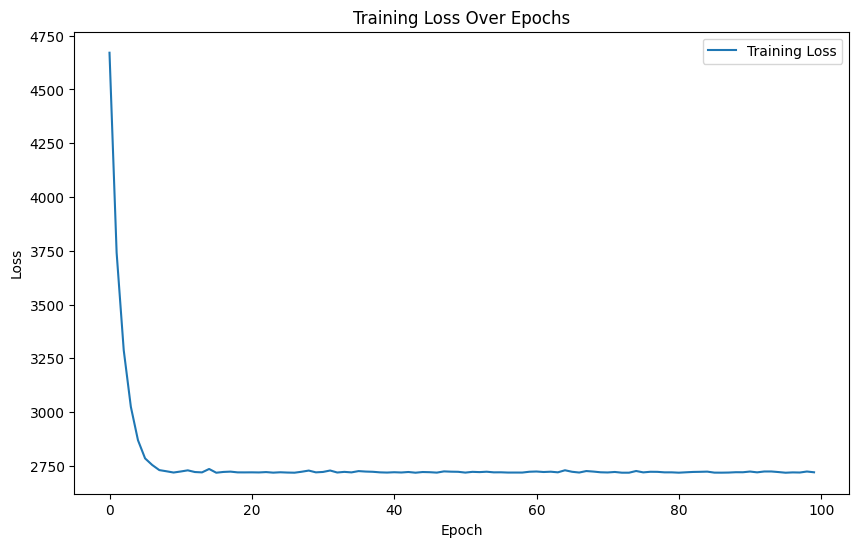

In [68]:
plot_loss_over_epochs(epoch_losses)

In [69]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

y_pred, y_true, mse, r2 = test_model(model, X_test_tensor, y_test_tensor)

predicted value: (3452, 1) true value: (3452,)
Mean Squared Error on the Test Set: 2463.69921875
R^2 Score: -0.0009046609136085237


/var/folders/8z/yxhm1c6x4bvg_s6d6w0cl6_80000gn/T/ipykernel_10310/3885395615.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/8z/yxhm1c6x4bvg_s6d6w0cl6_80000gn/T/ipykernel_10310/3885395615.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


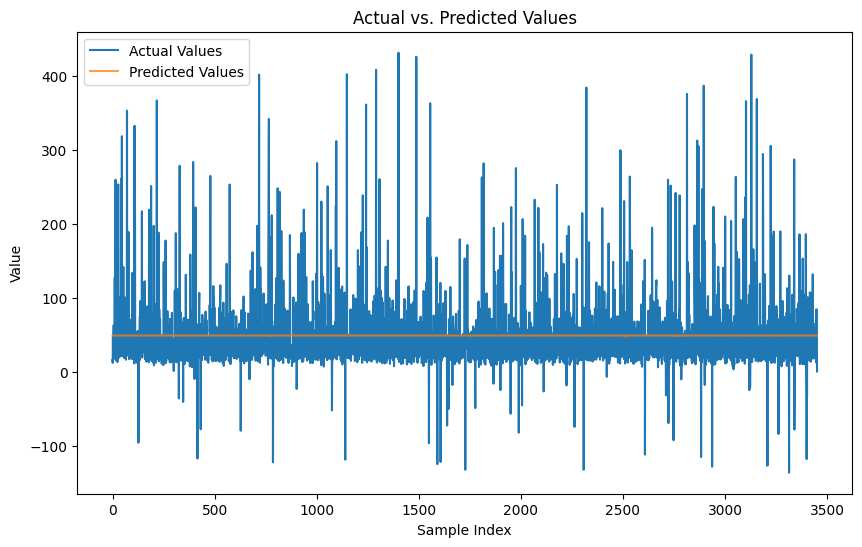

In [70]:
plot_actual_predicted(y_true, y_pred)


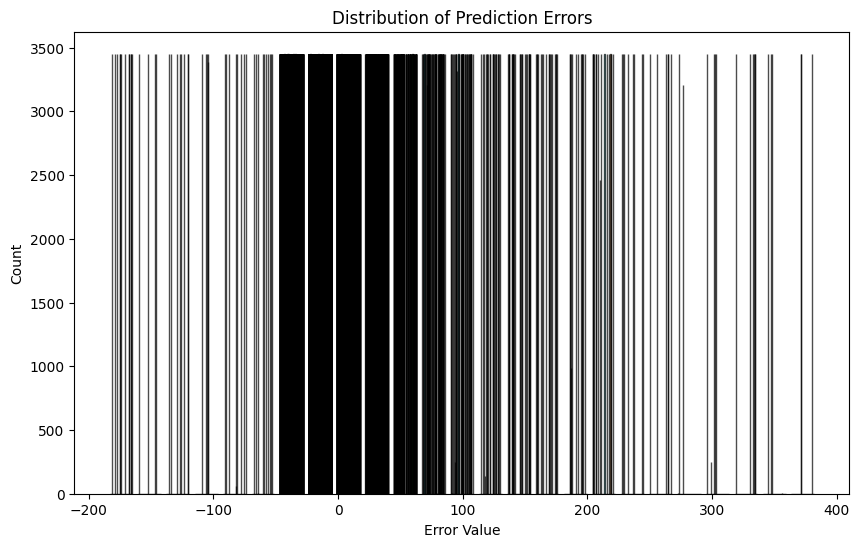

In [71]:
errors = y_true - y_pred
plot_distribution_error(errors)